In [1]:
import json
import numpy as np
import pandas as pd
import scipy.optimize as opt
import matplotlib.pyplot as plt
plt.style.use('_mpl-gallery')
plt.rcParams['font.family'] = ['SimHei', 'Times New Roman']

In [14]:
class const:
    label_en = 'CI'  # AF,AS,MI,CI
    label_ch = '脑梗'  # 房颤,动脉粥样硬化,心梗,脑梗
    confidence_score_f = 'std×pp'
    confidence_score_dict = r'..\..\PycharmProject-202412-集成学习\绘图数据【保留】\%s%s-confidence-score-dict-func=%s.json'
    degree = 3
    lam = 100
    density = 200
    threshhold = 2 * 10 ** -2
    decision_boundary_dict = r'%s%s-decision-boundary-dict-degree=%d-density=%d.json'

#### 数据准备、数据处理

In [3]:
def prepare_data():
    now_json_path_file_name = const.confidence_score_dict % (const.label_en, const.label_ch, const.confidence_score_f)
    confidence_score_dict = json.load(open(now_json_path_file_name, 'r', encoding='utf-8'))
    pred_pro_weighted_sum_true = confidence_score_dict["true"]["pred_pro_weighted_sum"]  # 正类数据：风险概率
    pred_pro_confidence_true = confidence_score_dict["true"]["pred_pro_confidence"]  # 正类数据：置信得分
    pred_pro_weighted_sum_false = confidence_score_dict["false"]["pred_pro_weighted_sum"]  # 负类数据：风险概率
    pred_pro_confidence_false = confidence_score_dict["false"]["pred_pro_confidence"]  # 负类数据：置信得分
    logistic_inputs_x = np.array([pred_pro_weighted_sum_true + pred_pro_weighted_sum_false, pred_pro_confidence_true + pred_pro_confidence_false])
    logistic_inputs_y = np.concatenate((np.ones(len(pred_pro_weighted_sum_true)), np.zeros(len(pred_pro_weighted_sum_false)))).astype(int)
    return logistic_inputs_x.T, logistic_inputs_y  # 返回模型输入：样本空间、标记空间
def feature_mapping(x1, x2, as_ndarray=False):
    data = {}
    for i in np.arange(const.degree + 1):
        for p in np.arange(i + 1):
            data["f%d%d" % (i - p, p)] = np.power(x1, i - p) * np.power(x2, p)
    return np.array(pd.DataFrame(data)) if as_ndarray else pd.DataFrame(data)

#### 拟合参数

In [4]:
def sigmoid(z):  # sigmoid函数
    return 1 / (1 + np.exp(-z))
def calc_regularized_loss(theta, x, y):  # 正则化损失函数
    classify_predict = sigmoid(np.dot(x, theta))  # 分类预测结果
    training_loss = np.mean(-y * np.log(classify_predict) - (1 - y) * np.log(1 - classify_predict))  # 训练损失
    parameters_loss = (1 / (2 * len(x))) * np.power(theta[1:], 2).sum()  # 参数损失：将参数也纳入损失函数中，目的是尽可能最小化参数，以尽可能避免过拟合
    return training_loss + parameters_loss  # 返回正则化损失，正则化损失=训练损失+参数损失
def calc_regularized_gradient(theta, x, y):  # 正则化梯度函数
    classify_predict = sigmoid(np.dot(x, theta))  # 分类预测结果
    training_gradient = (1 / len(x)) * np.dot(x.T, classify_predict - y)  # 训练梯度
    parameters_gradient_higher_term = (const.lam / len(x)) * theta[1:]  # 参数梯度（高次项参数）
    parameters_gradient = np.concatenate([np.array([0]), parameters_gradient_higher_term])  # 参数梯度（所有参数）
    return training_gradient + parameters_gradient  # 返回正则化梯度，正则化梯度=训练梯度+参数梯度
def feature_mapped_logistic_regression(logistic_inputs_x, logistic_inputs_y):
    inputs_x = feature_mapping(logistic_inputs_x[:, 0], logistic_inputs_x[:, 1], as_ndarray=True)
    theta = np.zeros(inputs_x.shape[1])  # 初始猜测的数组
    res = opt.minimize(fun=calc_regularized_loss, x0=theta, args=(inputs_x, logistic_inputs_y), method='TNC', jac=calc_regularized_gradient)  # 拟合
    final_theta = res.x  # 获取拟合参数
    return final_theta

#### 寻找决策边界上的离散点、拟合决策边界、绘制决策边界、保存决策边界坐标

In [5]:
def find_decision_boundary(theta):  # 寻找决策边界上的离散点
    x_interval_value = np.linspace(0, 1, const.density)  # 生成等距间隔值
    y_interval_value = np.linspace(0, 1, const.density)  # 生成等距间隔值
    coordinate_value = [(x, y) for x in x_interval_value for y in y_interval_value]  # 生成网格化坐标点(x, y)，坐标点数量为间隔值数量的平方
    x_coordinate, y_coordinate = zip(*coordinate_value)  # 遍历出每个坐标点的横坐标值、纵坐标值
    map_high_dimensional = feature_mapping(x_coordinate, y_coordinate)  # 对于mapped_coordinate，行数：间隔值数量的平方；列数：(const.degree+1)(const.degree+2)/2
    distance = np.dot(np.array(map_high_dimensional), theta)  # 矩阵叉乘。theta行数：高维空间的维数；列数：1。theta行数：高维空间的维数；列数：1
    decision = map_high_dimensional[np.abs(distance) < const.threshhold]
    # 笔记："*coordinate_value"表示将"坐标值"列表转化为"坐标值"元组，则返回的"横坐标值"、"纵坐标值"也都是元组数据格式
    # 笔记：将二维特征映射到高维空间中，该高维空间的维数是："(const.degree+1)(const.degree+2)/2"
    # 笔记：将训练所得的各个系数theta[i]，分别与每个高维坐标对应的坐标值相乘，所得结果为先前二维特征的"预测值"。该预测值可以理解为二维坐标点与决策边界的某种距离
    # 笔记：找到distance中绝对值小于阈值threshhold=0.002的元素，并得知这些元素在distance中的索引。再在map_high_dimensional上引用该索引，得到决策边界上的离散点
    # 笔记：此处阈值threshhold=0.002也可以理解为误差，即误差小于0.002，对应的坐标点(x,y)才能被看作是决策边界上的点，才能被选择
    # 笔记：decision就是决策边界上的离散点了。下一步，返回这些离散点在直角坐标系中的横坐标值（decision.f10=x1^1*x2^0）、纵坐标值（decision.f01=x1^0*x2^1）
    return decision.f10, decision.f01
def polyfit_boundary(boundary_x_coordinate, boundary_y_coordinate):
    coef = np.polyfit(boundary_x_coordinate, boundary_y_coordinate, 2)  # 二次拟合
    boundary_y_coordinate_fit = np.polyval(coef, boundary_x_coordinate)
    return boundary_y_coordinate_fit
def fit_func(x, a, b, c):  # 变量一定要放在第一个位置
    return a * x ** 2 + b * x + c
def curve_fit_boundary(boundary_x_coordinate, boundary_y_coordinate):
    popt, pcov = opt.curve_fit(fit_func, boundary_x_coordinate, boundary_y_coordinate)  # p0 = 1是因为只有a一参数
    boundary_y_coordinate_fit = fit_func(boundary_x_coordinate, popt[0], popt[1], popt[2])  # popt[0],popt[1],popt[2]分别代表参数a b c
    return popt, boundary_y_coordinate_fit
def draw_boundary(logistic_inputs_x, logistic_inputs_y, boundary_x_coordinate, boundary_y_coordinate, boundary_y_coordinate_fit):  # 用离散点模拟绘制决策边界
    fig_3 = plt.figure(figsize=(16, 8))
    ax1=fig_3.add_subplot(111)
    plt.scatter(logistic_inputs_x[:, 0][logistic_inputs_y == 0], logistic_inputs_x[:, 1][logistic_inputs_y == 0], label='错误分类', c='r', s=1)
    plt.scatter(logistic_inputs_x[:, 0][logistic_inputs_y == 1], logistic_inputs_x[:, 1][logistic_inputs_y == 1], label='正确分类', c='k', s=1)  # 按分类绘制数据样本点
    plt.scatter(boundary_x_coordinate, boundary_y_coordinate, c='g', s=5)
    plt.plot(boundary_x_coordinate, boundary_y_coordinate_fit, c='b')
    plt.legend(loc="lower right", shadow=True, fancybox=True)
    plt.rcParams.update({'font.size': 32})
    plt.xlabel('风险概率')
    plt.ylabel('置信得分')
    plt.title('')
    ax1.set_xlim([-0.02, 1.02])
    # ax1.set_ylim([0.75, 1.02])
    ax1.spines['bottom'].set_linewidth(3)#设置底部坐标轴的粗细
    ax1.spines['left'].set_linewidth(3)#设置左边坐标轴的粗细
    ax1.spines['right'].set_linewidth(3)#设置右边坐标轴的粗细
    ax1.spines['top'].set_linewidth(3)#设置上部坐标轴的粗细
    plt.show()

In [ ]:
def do_write_pic_data(boundary_x_coordinate, boundary_y_coordinate):
    boundary_coordinate_dict = {"boundary_x_coordinate": list(boundary_x_coordinate), "boundary_y_coordinate": list(boundary_y_coordinate)}  # json数据框
    json_name = const.decision_boundary_dict % (const.label_en, const.label_ch, const.degree, const.density)
    fp = open(json_name, 'w', encoding='utf-8')
    json.dump(boundary_coordinate_dict, fp, indent=4, ensure_ascii=False, sort_keys=False)
    fp.close()

In [11]:
# def do_work():
#     logistic_inputs_x, logistic_inputs_y = prepare_data()
#     final_theta = feature_mapped_logistic_regression(logistic_inputs_x, logistic_inputs_y)
#     boundary_x_coordinate, boundary_y_coordinate = find_decision_boundary(final_theta)
#     draw_boundary(logistic_inputs_x, logistic_inputs_y, boundary_x_coordinate, boundary_y_coordinate)
#     do_write_pic_data(boundary_x_coordinate, boundary_y_coordinate)
# if __name__ == '__main__':
#     do_work()

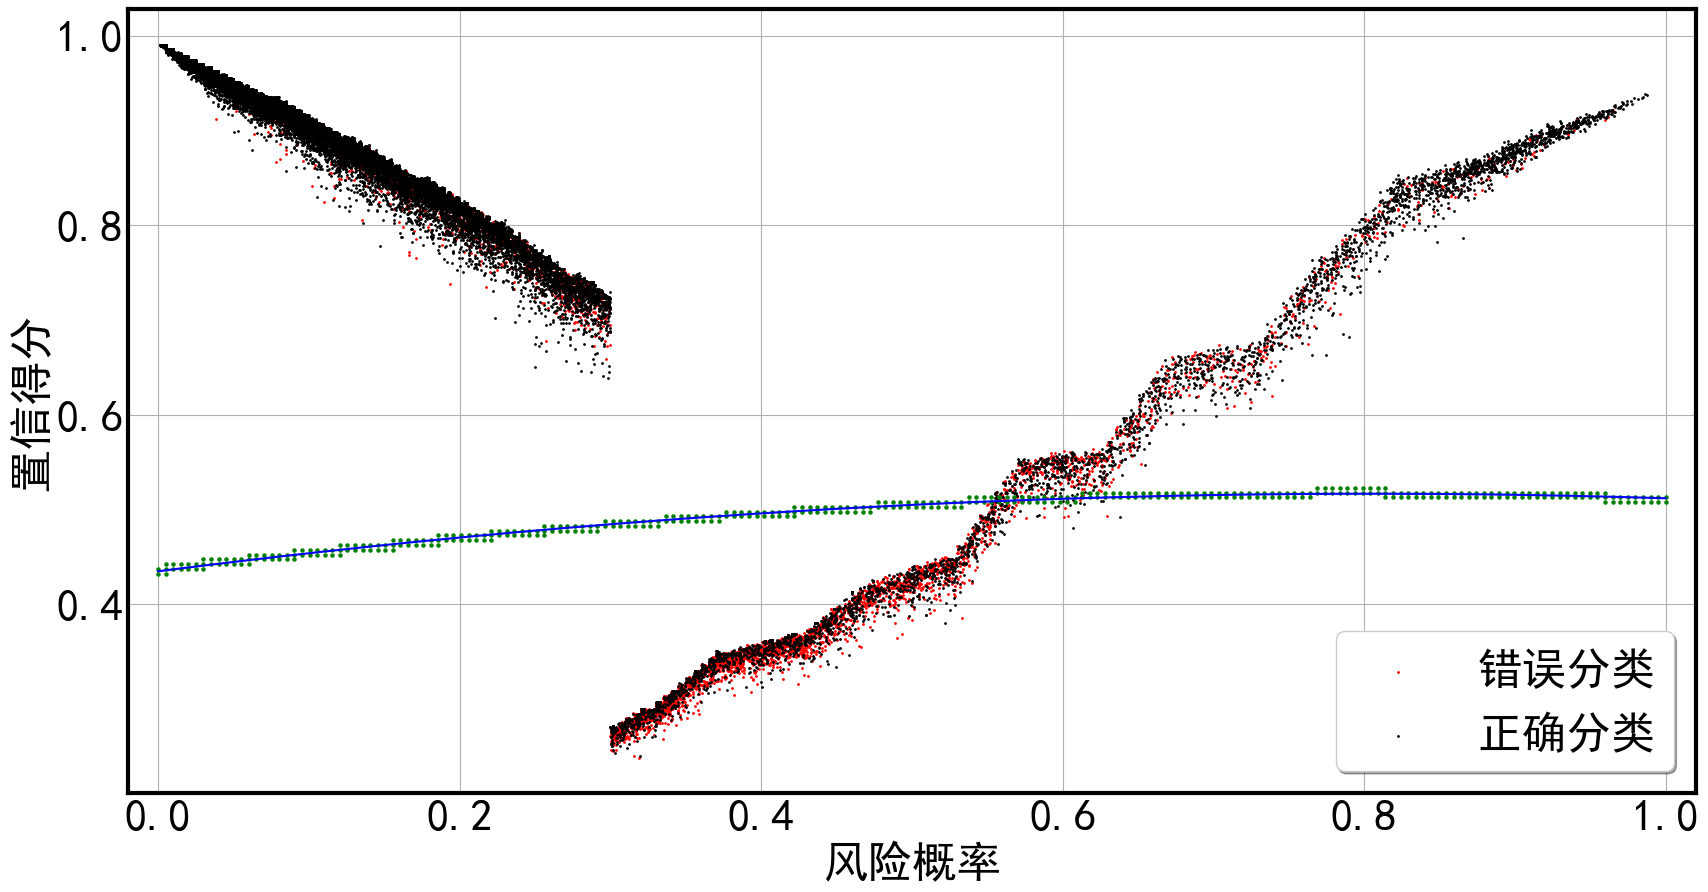

In [22]:
logistic_inputs_x, logistic_inputs_y = prepare_data()
final_theta = feature_mapped_logistic_regression(logistic_inputs_x, logistic_inputs_y)
boundary_x_coordinate, boundary_y_coordinate = find_decision_boundary(final_theta)
# boundary_y_coordinate_fit = polyfit_boundary(boundary_x_coordinate, boundary_y_coordinate)
popt, boundary_y_coordinate_fit = curve_fit_boundary(boundary_x_coordinate, boundary_y_coordinate)
draw_boundary(logistic_inputs_x, logistic_inputs_y, boundary_x_coordinate, boundary_y_coordinate, boundary_y_coordinate_fit)

In [7]:
true_difference=logistic_inputs_x[:, 1][logistic_inputs_y == 1] - fit_func(logistic_inputs_x[:, 0][logistic_inputs_y == 1], popt[0], popt[1], popt[2])
false_difference=logistic_inputs_x[:, 1][logistic_inputs_y == 0] - fit_func(logistic_inputs_x[:, 0][logistic_inputs_y == 0], popt[0], popt[1], popt[2])
up_true_index = np.where(true_difference>=0)[0]
up_false_index = np.where(false_difference>=0)[0]
down_true_index = np.where(true_difference<0)[0]
down_false_index = np.where(false_difference<0)[0]

print('%.3f * x ** 2 + %.3f * x + %.3f' % (popt[0], popt[1], popt[2]))
print(len(up_true_index),len(up_false_index),len(down_true_index),len(down_false_index))

-0.126 * x ** 2 + 0.203 * x + 0.435
38263 3130 1814 3153


In [65]:
print('high_accuracy:%.3f' % (len(up_true_index)/(len(up_true_index)+len(up_false_index))))
print('low_accuracy:%.3f' % (len(down_true_index)/(len(down_true_index)+len(down_false_index))))

high_accuracy:0.924
low_accuracy:0.365
